# Semantic Scene Segmentation
This notebook implements a Semantic Segmentation pipeline using TensorFlow/Keras.
It addresses the hackathon challenge of segmenting off-road environments.

## Steps:
1. Load and Preprocess Data
2. Visualize Data
3. Build U-Net Model
4. Train and Evaluate

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2
from glob import glob

# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


In [2]:
!nvidia-smi
import tensorflow as tf
print(tf.config.list_physical_devices("GPU"))

Sat Feb  7 06:12:03 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Mount Google Drive (Colab)
If the Drive mount prompt doesn’t appear or fails, try in order:
1. `Runtime → Restart runtime` and run this cell again.
2. Make sure you’re signed into the right Google account in the same browser tab.
3. Disable ad-blockers / privacy extensions for `colab.research.google.com`.
4. Allow third-party cookies / popups (or try an Incognito window).
5. Use the Files sidebar in Colab: **Files → Mount Drive** (it does the same thing).

In [17]:
import os
import shutil

# --- 1. SETUP PATHS ---
# This is where your data lives in Drive (Slow)
DRIVE_SOURCE = "/content/drive/MyDrive/Hackathon Project/data/offroad-seg-kaggle"

# This is where we want to move it (Fast)
LOCAL_DEST = "/content/fast_data"

# --- 2. COPY DATA (The Speed Fix) ---
if not os.path.exists(LOCAL_DEST):
    print(f"🚀 Copying data from Drive to Local VM... (Please wait)")
    # We use the shell command 'cp' because it's faster than Python's shutil
    !mkdir -p "{LOCAL_DEST}"
    !cp -r "{DRIVE_SOURCE}/." "{LOCAL_DEST}/"
    print("✅ Copy complete! Training will now be fast.")
else:
    print("✅ Data is already on local disk.")

# --- 3. UPDATE THE VARIABLE ---
# This is the line you asked for. It tells the rest of your code to use the fast folder.
DATA_DIR = LOCAL_DEST

# --- 4. RE-DEFINE PATHS ---
# We must update these derived paths too, or they will still point to the old location
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "train_images")
TRAIN_MASK_DIR = os.path.join(DATA_DIR, "train_masks")

print(f"Global DATA_DIR updated to: {DATA_DIR}")

✅ Data is already on local disk.
Global DATA_DIR updated to: /content/fast_data


In [19]:
import os
import shutil

# 1. Define source (Drive) and destination (Local VM)
SOURCE_DIR = "/content/drive/MyDrive/Hackathon Project/data/offroad-seg-kaggle"
LOCAL_DIR = "/content/data_local" 

# 2. Copy data ONLY if not already copied
if not os.path.exists(LOCAL_DIR):
    print("🚀 Copying data to local VM for high-speed training...")
    # Using shell command is often faster for many files
    !mkdir -p "{LOCAL_DIR}"
    !cp -r "{SOURCE_DIR}/." "{LOCAL_DIR}/"
    print("✅ Copy complete!")
else:
    print("✅ Data already exists locally.")

# 3. CRITICAL: Update your config to point to the LOCAL folder
DATA_DIR = LOCAL_DIR  # <--- This makes the magic happen
print(f"Data directory updated to: {DATA_DIR}")

✅ Data already exists locally.
Data directory updated to: /content/data_local


In [20]:
# Configuration
import sys

# Check if running in Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    # Mount Drive (safe to re-run)
    drive.mount('/content/drive', force_remount=False)
    # UPDATE THIS PATH to where you uploaded the data in your Drive
    DATA_DIR = "/content/drive/MyDrive/Hackathon Project/data/offroad-seg-kaggle"
    print(f"Running in Colab. Data directory set to: {DATA_DIR}")
else:
    # Local path
    DATA_DIR = "./data/offroad-seg-kaggle"
    print(f"Running locally. Data directory set to: {DATA_DIR}")

IMAGE_SIZE = 256
BATCH_SIZE = 8
NUM_CLASSES = 6 # Mapped classes: 0, 1, 2, 3, 4(was 27), 5(was 39)
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "train_images")
TRAIN_MASK_DIR = os.path.join(DATA_DIR, "train_masks")

# Get list of file paths
_all_train_images = sorted(glob(os.path.join(TRAIN_IMG_DIR, "*.png")) + glob(os.path.join(TRAIN_IMG_DIR, "*.jpg")))
_all_train_masks = sorted(glob(os.path.join(TRAIN_MASK_DIR, "*.png")) + glob(os.path.join(TRAIN_MASK_DIR, "*.jpg")))

def _index_by_stem(paths):
    indexed = {}
    for p in paths:
        stem = os.path.splitext(os.path.basename(p))[0]
        # keep first occurrence if duplicates exist
        indexed.setdefault(stem, p)
    return indexed

_img_by_stem = _index_by_stem(_all_train_images)
_mask_by_stem = _index_by_stem(_all_train_masks)
_common = sorted(set(_img_by_stem).intersection(_mask_by_stem))

# Paired lists (guaranteed same length + matching filenames)
train_images = [_img_by_stem[k] for k in _common]
train_masks = [_mask_by_stem[k] for k in _common]

print(f"Found {len(_all_train_images)} image files and {len(_all_train_masks)} mask files")
print(f"Paired {len(train_images)} image/mask matches")

_missing_imgs = sorted(set(_mask_by_stem).difference(_img_by_stem))
_missing_masks = sorted(set(_img_by_stem).difference(_mask_by_stem))
if _missing_imgs:
    print(f"Masks without images: {len(_missing_imgs)} (example: {_missing_imgs[0]})")
if _missing_masks:
    print(f"Images without masks: {len(_missing_masks)} (example: {_missing_masks[0]})")

if len(train_images) > 0:
    print(f"Sample image: {train_images[0]}")
    print(f"Sample mask: {train_masks[0]}")
else:
    print("ERROR: No paired data found! Please check your DATA_DIR path and dataset structure.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running in Colab. Data directory set to: /content/drive/MyDrive/Hackathon Project/data/offroad-seg-kaggle
Found 3112 image files and 3174 mask files
Paired 3112 image/mask matches
Masks without images: 62 (example: cc0000065)
Sample image: /content/drive/MyDrive/Hackathon Project/data/offroad-seg-kaggle/train_images/cc0000012.png
Sample mask: /content/drive/MyDrive/Hackathon Project/data/offroad-seg-kaggle/train_masks/cc0000012.png


In [21]:
# DEBUG: Run this if you are getting "Found 0 images" in Colab
# It will list what folder exists so you can correct the DATA_DIR path
if IN_COLAB:
    print("Listing contents of MyDrive to help you find the right path:")
    base_path = "/content/drive/MyDrive"
    if os.path.exists(base_path):
        print(os.listdir(base_path)[:10]) # Show first 10 folders
        
        # Check specific path
        if os.path.exists(DATA_DIR):
             print(f"\nSUCCESS: Found data directory at {DATA_DIR}")
             print("Contents:", os.listdir(DATA_DIR))
        else:
             print(f"\nERROR: Could not find {DATA_DIR}")
             print("Please check your folder names in Google Drive.")

Listing contents of MyDrive to help you find the right path:
['Result (2).jpg', 'Result (1).jpg', 'response sheet .pdf', 'Result.jpg', 'Guess It Game.gdoc', '1681828588725-68afdbaf-badb-4a6a-bdbb-09dd2d9c98ff_.jpg', '1687843839443.jpg', '16878441992051757455940209835804.jpg', 'IMG-20230627-WA0000.jpg', 'IMG-20230627-WA0001.jpg']

SUCCESS: Found data directory at /content/drive/MyDrive/Hackathon Project/data/offroad-seg-kaggle
Contents: ['test_images_padded', 'train_masks', 'train_images']


In [22]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if x is None:
        raise ValueError(f"Could not read mask: {path}")
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
    
    # Remap labels to 0-5
    # Found labels: [0, 1, 2, 3, 27, 39]
    new_x = np.zeros_like(x)
    new_x[x == 1] = 1
    new_x[x == 2] = 2
    new_x[x == 3] = 3
    new_x[x == 27] = 4
    new_x[x == 39] = 5
    # Value 0 remains 0
    
    x = new_x.astype(np.int32)
    return x

def tf_dataset(x, y, batch_size=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    
    def preprocess(x_path, y_path):
        def _preprocess(x_path, y_path):
            x = read_image(x_path.decode())
            y = read_mask(y_path.decode())
            return x, y

        x, y = tf.numpy_function(_preprocess, [x_path, y_path], [tf.float32, tf.int32])
        x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
        y.set_shape([IMAGE_SIZE, IMAGE_SIZE]) 
        return x, y

    
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Split data
from sklearn.model_selection import train_test_split
if len(train_images) > 0:
    train_x, val_x, train_y, val_y = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)
    print(f"Training: {len(train_x)}, Validation: {len(val_x)}")
    
    train_dataset = tf_dataset(train_x, train_y, batch_size=BATCH_SIZE)
    # Re-create validation dataset to ensure it uses the new read_mask logic if we re-run this cell
    val_dataset = tf_dataset(val_x, val_y, batch_size=BATCH_SIZE)
else:
    print("No data found to split.")

Training: 2489, Validation: 623


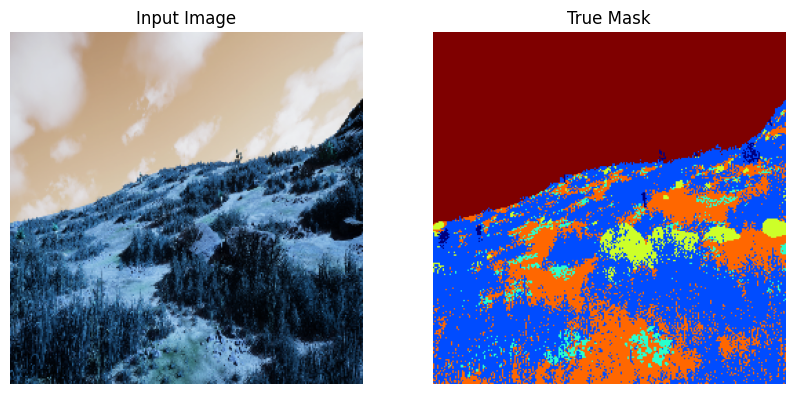

In [23]:
def display_sample(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        
        # Determine if the image is a mask (likely single channel or int) or input image
        img = display_list[i]
        if len(img.shape) == 2: # Mask (H, W)
             plt.imshow(img, cmap='jet', vmin=0, vmax=NUM_CLASSES-1)
        # elif img.shape[-1] == 1: # Mask (H, W, 1)
        #     plt.imshow(img[:, :, 0], cmap='jet', vmin=0, vmax=NUM_CLASSES-1)
        else:
             plt.imshow(img)
             
        plt.axis('off')
    plt.show()

if len(train_images) > 0:
    for image, mask in train_dataset.take(1):
        sample_image, sample_mask = image[0], mask[0]
        display_sample([sample_image, sample_mask])

In [24]:
def unet_model(output_channels, input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)

    return keras.Model(inputs=[inputs], outputs=[outputs])

model = unet_model(NUM_CLASSES)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 16,    │  9,438,208 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 32, 32,    │  2,097,664 │ conv2d_28[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,032,070 (118.38 MB)

 Trainable params: 31,032,070 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# IoU Metric
class MeanIoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='mean_iou', **kwargs):
        super(MeanIoU, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.iou_metric = tf.keras.metrics.MeanIoU(num_classes=num_classes)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.cast(y_true, y_pred.dtype)
        self.iou_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        return self.iou_metric.result()

    def reset_state(self):
        self.iou_metric.reset_state()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', MeanIoU(num_classes=NUM_CLASSES)])

In [26]:
import os
from glob import glob

# Optional speed-up for Colab: copy dataset from Drive -> local VM storage
# This makes training/input pipeline much faster than reading from Drive.
DRIVE_SOURCE = "/content/drive/MyDrive/Hackathon Project/data/offroad-seg-kaggle"
LOCAL_DEST = "/content/fast_data"

# Copy the data (one-time per runtime disk)
if not os.path.exists(LOCAL_DEST):
    print(f"Copying data from {DRIVE_SOURCE} to local VM at {LOCAL_DEST}...")
    # IPython supports {var} substitution in shell commands
    !cp -r "{DRIVE_SOURCE}" "{LOCAL_DEST}"
    print("Copy complete. Data is now on the fast local drive.")
else:
    print(f"Local data already exists at {LOCAL_DEST}")

# Point the pipeline at the local copy
DATA_DIR = LOCAL_DEST
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "train_images")
TRAIN_MASK_DIR = os.path.join(DATA_DIR, "train_masks")

# Re-load and re-pair file lists (keeps images/masks aligned)
_all_train_images = sorted(glob(os.path.join(TRAIN_IMG_DIR, "*.png")) + glob(os.path.join(TRAIN_IMG_DIR, "*.jpg")))
_all_train_masks = sorted(glob(os.path.join(TRAIN_MASK_DIR, "*.png")) + glob(os.path.join(TRAIN_MASK_DIR, "*.jpg")))

def _index_by_stem(paths):
    indexed = {}
    for p in paths:
        stem = os.path.splitext(os.path.basename(p))[0]
        indexed.setdefault(stem, p)
    return indexed

_img_by_stem = _index_by_stem(_all_train_images)
_mask_by_stem = _index_by_stem(_all_train_masks)
_common = sorted(set(_img_by_stem).intersection(_mask_by_stem))
train_images = [_img_by_stem[k] for k in _common]
train_masks = [_mask_by_stem[k] for k in _common]

print(f"Reset data paths to: {DATA_DIR}")
print(f"Found {len(_all_train_images)} image files and {len(_all_train_masks)} mask files locally")
print(f"Paired {len(train_images)} image/mask matches locally")

Local data already exists at /content/fast_data
Reset data paths to: /content/fast_data
Found 393 image files and 0 mask files locally
Paired 0 image/mask matches locally


In [27]:
# Training
EPOCHS = 10

# Guard against running this cell before data/model setup cells.
required_vars = ["DATA_DIR", "model", "train_dataset", "val_dataset", "train_images"]
missing = [name for name in required_vars if name not in globals()]
if missing:
    print("Cannot start training yet. Missing variables:", missing)
    print("Run the notebook cells above that: (1) set DATA_DIR + load file paths, (2) build tf.data datasets, (3) define/compile the model.")
else:
    if len(train_images) > 0:
        import time
        from datetime import datetime
        
        run_tag = datetime.now().strftime("%Y%m%d-%H%M%S")
        run_dir = os.path.join("runs", f"segmentation_{run_tag}")
        os.makedirs(run_dir, exist_ok=True)
        
        done_marker = os.path.join(run_dir, "training_done.txt")
        if os.path.exists(done_marker):
            os.remove(done_marker)
        
        callbacks = [
            tf.keras.callbacks.CSVLogger(os.path.join(run_dir, "training_log.csv"), append=False),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(run_dir, "best_model.keras"),
                monitor="val_loss",
                save_best_only=True,
                verbose=1,
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=3,
                restore_best_weights=True,
                verbose=1,
            ),
        ]
        
        print(f"Logs/checkpoints will be saved to: {run_dir}")
        start_time = time.time()
        history = model.fit(
            train_dataset,
            epochs=EPOCHS,
            validation_data=val_dataset,
            callbacks=callbacks,
        )
        elapsed_s = time.time() - start_time
        
        # Write a marker file so you can quickly check completion from the file system.
        with open(done_marker, "w", encoding="utf-8") as f:
            f.write(f"TRAINING COMPLETE\n")
            f.write(f"run_dir={run_dir}\n")
            f.write(f"epochs_requested={EPOCHS}\n")
            f.write(f"epochs_ran={len(history.history.get('loss', []))}\n")
            f.write(f"elapsed_seconds={elapsed_s:.2f}\n")
            if "val_loss" in history.history:
                f.write(f"best_val_loss={min(history.history['val_loss']):.6f}\n")
        
        print("\n=== TRAINING COMPLETE ===")
        print(f"Run directory: {run_dir}")
        print(f"Marker file:  {done_marker}")
    else:
        print("Skipping training, no data.")

Skipping training, no data.


In [ ]:
# Validation visualization
if len(train_images) > 0:
    for image, mask in val_dataset.take(3):
        pred_mask = model.predict(image)
        pred_mask = tf.argmax(pred_mask, axis=-1)
        pred_mask = pred_mask[0] # Take first from batch
        
        display_sample([image[0], mask[0], pred_mask])

# Submission Generation
The following cells generate the submission files.
We will:
1. Predict masks for all test images.
2. Convert the predicted classes back to their original IDs (e.g., 4 -> 27).
3. Save the results as a `submission.csv` (Run-Length Encoded) and as PNG files in a folder.

In [ ]:
import pandas as pd

TEST_IMG_DIR = os.path.join(DATA_DIR, "test_images_padded")
test_paths = sorted(glob(os.path.join(TEST_IMG_DIR, "*.png")) + glob(os.path.join(TEST_IMG_DIR, "*.jpg")))
print(f"Found {len(test_paths)} test images")

# Helper to map predictions back to original IDs
# We mapped: 27->4, 39->5. We need to reverse this.
id_mapping = {0:0, 1:1, 2:2, 3:3, 4:27, 5:39}

def rle_encode(mask):
    """
    Encodes a mask (H, W) into a string "start_pixel length ..."
    Kaggle standard uses column-major indexing (F-style).
    """
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Create submission directory for image-based submission
submission_dir = "submission_masks"
os.makedirs(submission_dir, exist_ok=True)

data = []

print("Generating predictions...")
for i, path in enumerate(test_paths):
    # 1. Read and Process
    filename = os.path.basename(path)
    # Read original to get dimensions
    orig_img = cv2.imread(path)
    h, w = orig_img.shape[:2]
    
    # Preprocess for model
    x = read_image(path)
    x = np.expand_dims(x, axis=0) # Batch dim
    
    # 2. Predict
    pred = model.predict(x, verbose=0)
    pred_mask = np.argmax(pred, axis=-1)[0] # (256, 256)
    
    # 3. Resize back to original size (Nearest Neighbor to keep class IDs)
    pred_mask_orig = cv2.resize(pred_mask.astype(np.uint8), (w, h), interpolation=cv2.INTER_NEAREST)
    
    # 4. Map back to original IDs
    final_mask = np.copy(pred_mask_orig)
    for k, v in id_mapping.items():
        final_mask[pred_mask_orig == k] = v
        
    # 5. Option A: Save as PNG
    cv2.imwrite(os.path.join(submission_dir, filename), final_mask)
    
    # 6. Option B: RLE Encoding (for CSV)
    # Note: RLE usually done on binary masks per class, or flat for semantic?
    # Provided here is a flattened RLE of the raw values (uncommon) or we might need one row per image.
    # Assuming one row per image for this hackathon type:
    rle = rle_encode(final_mask)
    data.append([filename, rle])
    
    if i % 10 == 0:
        print(f"Processed {i}/{len(test_paths)}")

# Save CSV
df = pd.DataFrame(data, columns=['id', 'rle_mask'])
df.to_csv('submission.csv', index=False)
print(f"Saved submission.csv and images to {submission_dir}/")